[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



--- Entrenando y Guardando Modelo: Regresión Logística ---

 EVALUACIÓN AVANZADA DEL MODELO: Regresión Logística

--- Reporte de Clasificación ---
                precision    recall  f1-score   support

No Crítico (0)       0.83      0.81      0.82        72
   Crítico (1)       0.81      0.83      0.82        72

      accuracy                           0.82       144
     macro avg       0.82      0.82      0.82       144
  weighted avg       0.82      0.82      0.82       144


Mostrando Matriz de Confusión...


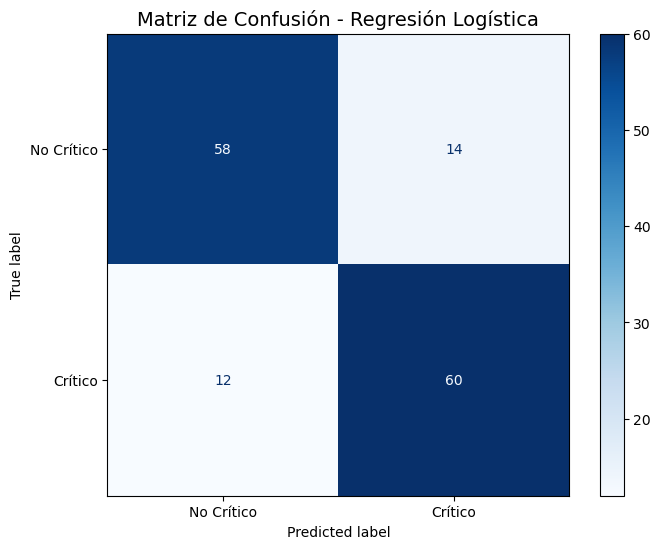


Mostrando Curva Precisión-Recall...


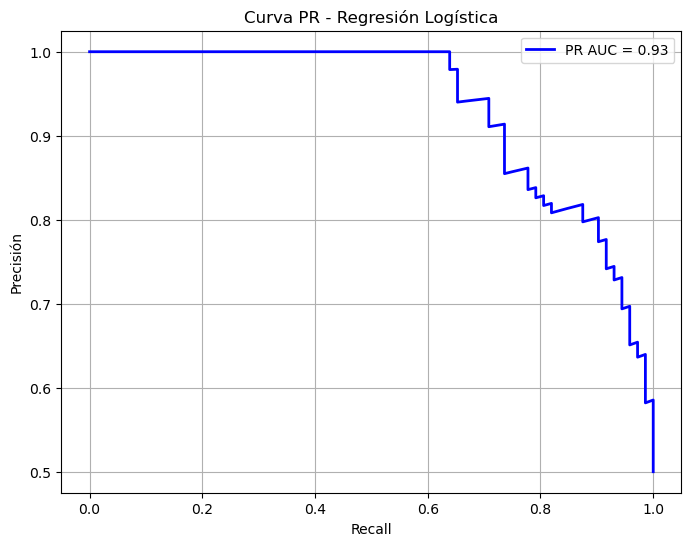


Mostrando Curva ROC-AUC...


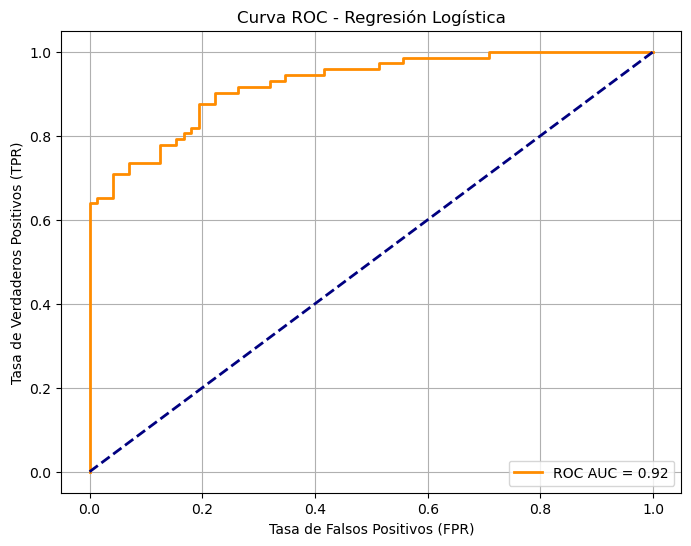


--- Métrica de Ranking: Recall@k ---
Recall@10: 13.89% (10 de 72 críticos encontrados)
Recall@20: 27.78% (20 de 72 críticos encontrados)
Recall@30: 41.67% (30 de 72 críticos encontrados)
Recall@50: 65.28% (47 de 72 críticos encontrados)

--- Entrenando y Guardando Modelo: Naive Bayes ---

 EVALUACIÓN AVANZADA DEL MODELO: Naive Bayes

--- Reporte de Clasificación ---
                precision    recall  f1-score   support

No Crítico (0)       0.88      0.78      0.82        72
   Crítico (1)       0.80      0.89      0.84        72

      accuracy                           0.83       144
     macro avg       0.84      0.83      0.83       144
  weighted avg       0.84      0.83      0.83       144


Mostrando Matriz de Confusión...


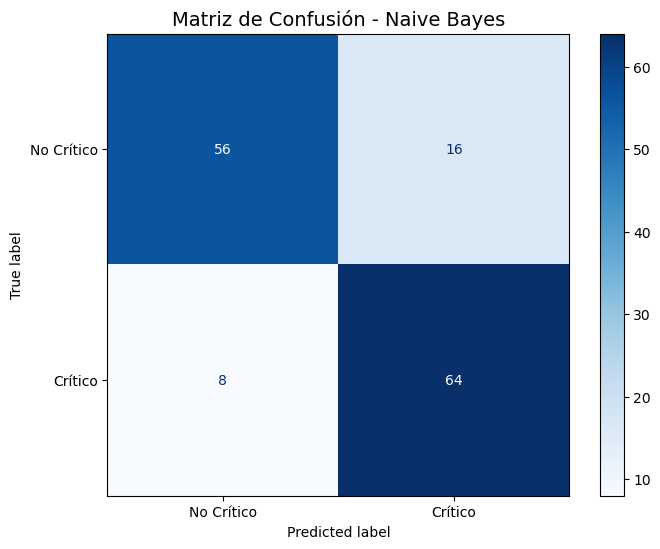


Mostrando Curva Precisión-Recall...


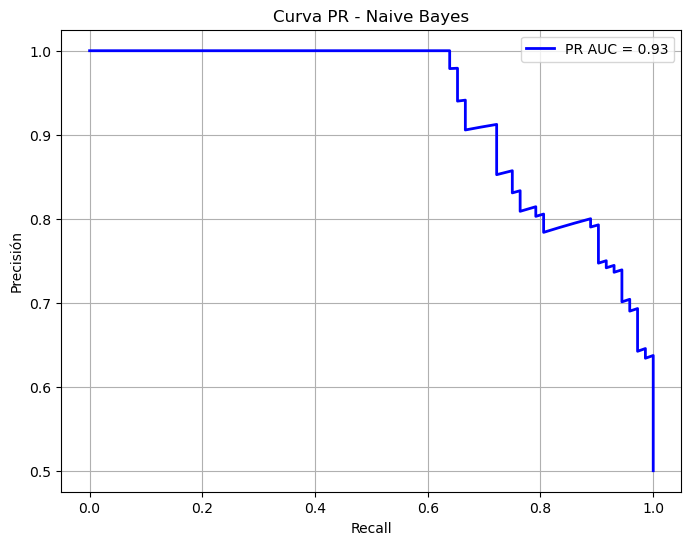


Mostrando Curva ROC-AUC...


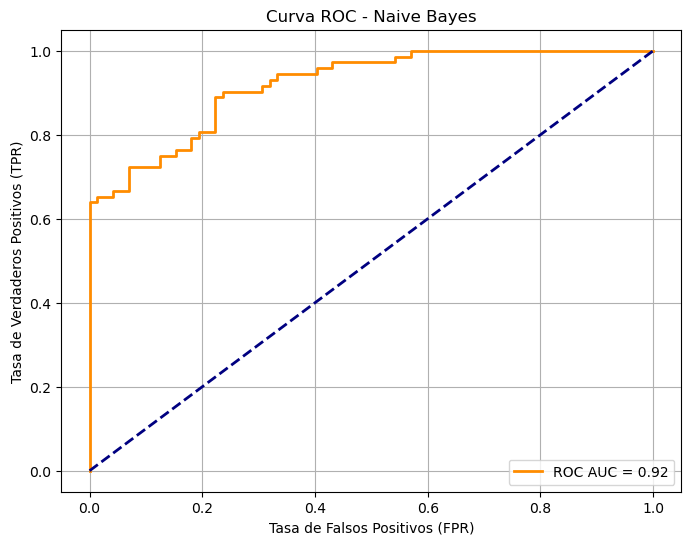


--- Métrica de Ranking: Recall@k ---
Recall@10: 13.89% (10 de 72 críticos encontrados)
Recall@20: 27.78% (20 de 72 críticos encontrados)
Recall@30: 41.67% (30 de 72 críticos encontrados)
Recall@50: 65.28% (47 de 72 críticos encontrados)


In [1]:
# 1. PREPARACIÓN DEL ENTORNO
# Importamos todas las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
# --- IMPORTACIONES AÑADIDAS ---
from sklearn.metrics import (classification_report, confusion_matrix, precision_recall_curve, 
                             auc, ConfusionMatrixDisplay, roc_curve, roc_auc_score)
import os
import string
import nltk
import unicodedata
import joblib

# Descargar y definir las 'stopwords'
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

# 2. FUNCIONES (Las funciones de carga y preprocesamiento no cambian)
def crear_dataset_desde_carpetas(ruta_no_criticos, ruta_criticos):
    textos, etiquetas = [], []
    for dirpath, _, filenames in os.walk(ruta_no_criticos):
        for fname in filenames:
            if fname.endswith(".txt"):
                with open(os.path.join(dirpath, fname), 'r', encoding='utf-8') as f:
                    textos.append(f.read()); etiquetas.append(0)
    for dirpath, _, filenames in os.walk(ruta_criticos):
        for fname in filenames:
            if fname.endswith(".txt"):
                with open(os.path.join(dirpath, fname), 'r', encoding='utf-8') as f:
                    textos.append(f.read()); etiquetas.append(1)
    return pd.DataFrame({'texto': textos, 'etiqueta': etiquetas})

def remover_acentos(texto):
    forma_nfd = unicodedata.normalize('NFD', texto)
    return "".join([c for c in forma_nfd if not unicodedata.combining(c)])

def preprocess_text(text):
    text = text.lower()
    text = remover_acentos(text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# --- FUNCIÓN DE EVALUACIÓN MODIFICADA ---
def evaluacion_avanzada(nombre_modelo, y_true, y_pred, y_probs):
    print("\n" + "="*60)
    print(f" EVALUACIÓN AVANZADA DEL MODELO: {nombre_modelo}")
    print("="*60)
    
    # 1. Reporte de Clasificación (sin cambios)
    print("\n--- Reporte de Clasificación ---")
    print(classification_report(y_true, y_pred, target_names=['No Crítico (0)', 'Crítico (1)']))
    
    # 2. Matriz de Confusión (sin cambios)
    print("\nMostrando Matriz de Confusión...")
    fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax_cm, display_labels=['No Crítico', 'Crítico'], cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre_modelo}', fontsize=14)
    plt.savefig(f'matriz_confusion_{nombre_modelo.replace(" ", "_").lower()}.png')
    plt.show()
    
    # 3. Curva PR (sin cambios)
    print("\nMostrando Curva Precisión-Recall...")
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, lw=2, color='blue', label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall'); plt.ylabel('Precisión'); plt.title(f'Curva PR - {nombre_modelo}'); plt.legend(); plt.grid(True)
    plt.savefig(f'curva_pr_{nombre_modelo.replace(" ", "_").lower()}.png')
    plt.show()

    # --- 4. NUEVA VISUALIZACIÓN: CURVA ROC-AUC ---
    print("\nMostrando Curva ROC-AUC...")
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Línea de referencia
    plt.xlabel('Tasa de Falsos Positivos (FPR)'); plt.ylabel('Tasa de Verdaderos Positivos (TPR)'); plt.title(f'Curva ROC - {nombre_modelo}'); plt.legend(loc="lower right"); plt.grid(True)
    plt.savefig(f'curva_roc_{nombre_modelo.replace(" ", "_").lower()}.png')
    plt.show()
    
    # 5. Recall@k (sin cambios)
    def calculate_recall_at_k(y_true_k, y_scores_k, k):
        desc_score_indices = np.argsort(y_scores_k, kind="mergesort")[::-1]
        top_k_indices = desc_score_indices[:k]
        num_positives = np.sum(y_true_k.iloc[top_k_indices])
        total_positives = np.sum(y_true_k)
        return num_positives / total_positives if total_positives > 0 else 0
        
    print("\n--- Métrica de Ranking: Recall@k ---")
    total_criticos = np.sum(y_true)
    for k in [10, 20, 30, 50]:
        if k <= len(y_true):
            recall_k = calculate_recall_at_k(y_true, pd.Series(y_probs), k)
            encontrados = int(recall_k * total_criticos)
            print(f"Recall@{k}: {recall_k:.2%} ({encontrados} de {total_criticos} críticos encontrados)")

# --- El resto del script (Carga, División, Entrenamiento) permanece igual ---

# 3. CARGA Y PREPROCESAMIENTO DE DATOS
# (Asegúrate de que estas carpetas existan y contengan datos para que el script se ejecute)
CARPETA_NO_CRITICOS = 'Informes_Anonimizados/no_criticos'
CARPETA_CRITICOS = 'Informes_Anonimizados/criticos'
if not os.path.exists(CARPETA_NO_CRITICOS): os.makedirs(CARPETA_NO_CRITICOS)
if not os.path.exists(CARPETA_CRITICOS): os.makedirs(CARPETA_CRITICOS)
# Crear archivos dummy si las carpetas están vacías
if not os.listdir(CARPETA_NO_CRITICOS):
    with open(os.path.join(CARPETA_NO_CRITICOS, "informe1.txt"), "w") as f: f.write("examen normal sin hallazgos")
if not os.listdir(CARPETA_CRITICOS):
    with open(os.path.join(CARPETA_CRITICOS, "informe2.txt"), "w") as f: f.write("se observa una fractura critica")
        
df = crear_dataset_desde_carpetas(CARPETA_NO_CRITICOS, CARPETA_CRITICOS)
df['texto_limpio'] = df['texto'].apply(preprocess_text)

# 4. DIVISIÓN Y VECTORIZACIÓN
X = df['texto_limpio']
y = df['etiqueta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# (El resto del código de esta sección no requiere cambios)

# 5. ENTRENAMIENTO, GUARDADO Y EVALUACIÓN DE MODELOS
# (El código de esta sección no requiere cambios)
# -Modelo 1: Regresión Logística
print("\n--- Entrenando y Guardando Modelo: Regresión Logística ---")
pipeline_lr = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_probs_lr = pipeline_lr.predict_proba(X_test)[:, 1]
evaluacion_avanzada("Regresión Logística", y_test, y_pred_lr, y_pred_probs_lr)

# -Modelo 2: Naive Bayes
print("\n--- Entrenando y Guardando Modelo: Naive Bayes ---")
pipeline_nb = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
    ('classifier', MultinomialNB())
])
pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)
y_pred_probs_nb = pipeline_nb.predict_proba(X_test)[:, 1]
evaluacion_avanzada("Naive Bayes", y_test, y_pred_nb, y_pred_probs_nb)